<a href="https://colab.research.google.com/github/rohith033/BTP/blob/main/version_2_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install 'shimmy'
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [ ]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback
from osgeo import gdal

In [ ]:
# Load the raster file
raster = gdal.Open('/content/Depth (Max) (1).Terrain.needed_tif.tif')
band = raster.GetRasterBand(1)  # Assuming depth is in band 1
depth_data = band.ReadAsArray()
# Get geotransformation
geotransform = raster.GetGeoTransform()

In [ ]:
def get_flat_index_neighbors_with_diagonals(flat_index, num_rows, num_cols):
    i = flat_index // num_cols
    j = flat_index % num_cols
    neighbors = {}

    # Direct neighbors
    if i > 0 and (i-1) * num_cols + j<num_rows*num_cols:
        neighbors['top'] = (i-1) * num_cols + j
    if i < num_rows - 1 and (i+1) * num_cols + j<num_rows*num_cols:
        neighbors['bottom'] = (i+1) * num_cols + j
    if j > 0 and i * num_cols + (j-1) < num_rows*num_cols :
        neighbors['left'] = i * num_cols + (j-1)
    if j < num_cols - 1 and i * num_cols + (j+1) < num_rows*num_cols:
        neighbors['right'] = i * num_cols + (j+1)

    # Diagonal neighbors
    if i > 0 and j > 0 and (i-1) * num_cols + (j-1) < num_rows*num_cols:
        neighbors['top_left'] = (i-1) * num_cols + (j-1)
    if i > 0 and j < num_cols - 1 and (i-1) * num_cols + (j+1) <num_rows*num_cols:
        neighbors['top_right'] = (i-1) * num_cols + (j+1)
    if i < num_rows - 1 and j > 0 and (i+1) * num_cols + (j-1) < num_rows*num_cols:
        neighbors['bottom_left'] = (i+1) * num_cols + (j-1)
    if i < num_rows - 1 and j < num_cols - 1 and (i+1) * num_cols + (j+1)<num_rows*num_cols:
        neighbors['bottom_right'] = (i+1) * num_cols + (j+1)

    return neighbors

In [ ]:
num_rows, num_cols = depth_data.shape
lats = np.array([geotransform[3] + geotransform[5] * i for i in range(num_rows)])
longs = np.array([geotransform[0] + geotransform[1] * j for j in range(num_cols)])
# Create an empty list to store the data
data_matrix = []

# Iterate through each cell
for i in range(num_rows):
    for j in range(num_cols):
        lat = lats[i]
        lon = longs[j]
        depth = depth_data[i, j]
        data_matrix.append([lat, lon, depth])

# Optionally convert to a numpy array for better handling
data_matrix = np.array(data_matrix)
data_matrix[data_matrix == -9999] = 0

In [ ]:
total_states =  4000
environments = []

In [ ]:
def make_env(flat_index,base_env,i,j):
  if i<0 or j<0 or i>8 or j>8 or base_env[i][j] != 0:
    return
  base_env[i][j] = data_matrix[flat_index][2]
  if base_env[i][j] == 0:
    base_env[i][j]  = 0.0001
  space = get_flat_index_neighbors_with_diagonals(flat_index,num_rows,num_cols)
  if 'top' in space:
    make_env(space['top'],base_env,i-1,j)
  if 'bottom' in space:
    make_env(space['bottom'],base_env,i+1,j)
  if 'left' in space:
    make_env(space['left'],base_env,i,j-1)
  if 'right' in space:
    make_env(space['right'],base_env,i,j+1)
  return

In [ ]:
for flat_index , depth_info in enumerate(data_matrix):
  if total_states == 0:
    break
  if depth_info[2] > 0.99:
    total_states-=1
    base_env = np.zeros((9,9))
    make_env(flat_index,base_env,4,4)
    environments.append(base_env)

In [ ]:

land_data_1=['BCBCFBBFC',
 'CCCCBBCCC',
 'CBBCBBCCB',
 'CCCCCCBCC',
 'CCCCCCBBC',
 'CFCFCCBCC',
 'CCFCCCCCC',
 'CBCFCBCFB',
 'CBFFCCBBB']


In [ ]:
['CBBBFFCFC', 'CCCCCCBCB', 'CBBBBBCCB', 'CCCCCCCCC', 'CCCCCCBCC', 'CFCCFCCCC', 'CFCCCCCCC', 'BCCFCBFCB', 'FBCFCCBBB']
['BBBBFCBBC', 'CCBCCCBCC', 'BBBCBBCCB', 'CBCCCCBCC', 'CCCCCCCBC', 'CFFCCCBCC', 'CCCCCCCCC', 'CBCFCBBFB', 'CCFBCCBBB']
['BCBBCCCBC', 'CCCCBBCCC', 'CBCCBBBCB', 'CCCCCCCCC', 'CCCCCCCBB', 'CFCCBCCCC', 'CCFCFCCCF', 'BBCFCBBFB', 'CBFFCBBFB']
['BCBCBBBFC', 'CCBCCBCCC', 'BBCBBBCBB', 'CCCCCCBCC', 'CCCCCCBBC', 'BCCFCCFCC', 'CCFFCCCCC', 'CBCFCBCBF', 'CBBFCCBBB']
['CCBCBBBFC', 'CCCBBBCCC', 'BCBCBBCCB', 'CCCCCCBCC', 'CCCCCCCBC', 'CFCFCCBCC', 'CCFCFCCCC', 'CCBFCBCBC', 'CBCCCBBBF']
['BCBCCBBCC', 'CCCCBBCCC', 'BBBBBCCCC', 'CCCCCCCCC', 'CCCCCCBBC', 'CCFFCCBCB', 'CCCCCCCCC', 'CBBBCFBBB', 'CBFFCCBBB']
['BBBCBBBBC', 'CCCCCCCCB', 'BBBBCCCCC', 'BCCCCCCCC', 'CCCCCCBCC', 'CFCCBCCCC', 'CCCCCCCCC', 'CCBFCFCBB', 'CBFFCCBBB']
['BBBCFBCFC', 'CCCCBCCCC', 'BBBBBBCBC', 'CCCCBCCBB', 'CCBCCCCCC', 'CCCFFCBCC', 'CCFCCCCCC', 'CBCBCBBBB', 'CBFFCCFBB']
['BCCCFBBCB', 'BCCCCBCCC', 'CBBCCBBCB', 'CCCBCBCBC', 'BBCCBCBBC', 'CFCFCBCCF', 'CCCCCCFCC', 'CBFFFBCFC', 'BBFFCCCBB']
['BCBCBBBBC', 'CCCCCBCCC', 'CBBBBBCCB', 'CCCCCCCCC', 'CCBCCCBBC', 'CFCFCBCCC', 'CCFCCCCCC', 'CBCCCBCFB', 'CBBFCCBBC']
[['CBBBFFCFC', 'CCCCCCBCB', 'CBBBBBCCB', 'CCCCCCCCC', 'CCCCCCBCC', 'CFCCFCCCC', 'CFCCCCCCC', 'BCCFCBFCB', 'FBCFCCBBB'],
 ['BBBBFCBBC', 'CCBCCCBCC', 'BBBCBBCCB', 'CBCCCCBCC', 'CCCCCCCBC', 'CFFCCCBCC', 'CCCCCCCCC', 'CBCFCBBFB', 'CCFBCCBBB'],
  ['BCBBCCCBC', 'CCCCBBCCC', 'CBCCBBBCB', 'CCCCCCCCC', 'CCCCCCCBB', 'CFCCBCCCC', 'CCFCFCCCF', 'BBCFCBBFB', 'CBFFCBBFB'],
   ['BCBCBBBFC', 'CCBCCBCCC', 'BBCBBBCBB', 'CCCCCCBCC', 'CCCCCCBBC', 'BCCFCCFCC', 'CCFFCCCCC', 'CBCFCBCBF', 'CBBFCCBBB'],
  ['CCBCBBBFC', 'CCCBBBCCC', 'BCBCBBCCB', 'CCCCCCBCC', 'CCCCCCCBC', 'CFCFCCBCC', 'CCFCFCCCC', 'CCBFCBCBC', 'CBCCCBBBF'],
   ['BCBCCBBCC', 'CCCCBBCCC', 'BBBBBCCCC', 'CCCCCCCCC', 'CCCCCCBBC', 'CCFFCCBCB', 'CCCCCCCCC', 'CBBBCFBBB', 'CBFFCCBBB'],
    ['BBBCBBBBC', 'CCCCCCCCB', 'BBBBCCCCC', 'BCCCCCCCC', 'CCCCCCBCC', 'CFCCBCCCC', 'CCCCCCCCC', 'CCBFCFCBB', 'CBFFCCBBB'],
  ['BBBCFBCFC', 'CCCCBCCCC', 'BBBBBBCBC', 'CCCCBCCBB', 'CCBCCCCCC', 'CCCFFCBCC', 'CCFCCCCCC', 'CBCBCBBBB', 'CBFFCCFBB'],
   ['BCCCFBBCB', 'BCCCCBCCC', 'CBBCCBBCB', 'CCCBCBCBC', 'BBCCBCBBC', 'CFCFCBCCF', 'CCCCCCFCC', 'CBFFFBCFC', 'BBFFCCCBB'],
  ['BCBCBBBBC', 'CCCCCBCCC', 'CBBBBBCCB', 'CCCCCCCCC', 'CCBCCCBBC', 'CFCFCBCCC', 'CCFCCCCCC', 'CBCCCBCFB', 'CBBFCCBBC']]

In [ ]:
class CustomFrozenLakeEnv(gym.Env):
    def __init__(self,depth_data,land_data):
        self.desc = land_data

        self.visited = set()
        self.flag = 0
        # Generate random depths between 0.5 and 5 for 'C' blocks
        self.depth_map = np.array(depth_data)
        self.ncols = self.depth_map[0].shape[0]
        self.colm = self.ncols
        self.nrows = 9
        self.nS = 81
        self.nA = 8  # Define the number of actions (left, down, right, up)
        self.start_state = self._get_state(row=4, col=4)
        min_depth_point = np.unravel_index(np.argmin(self.depth_map), self.depth_map.shape)
        self.thersold = 0.5
        self.goal_state = self._get_state(row=min_depth_point[0], col=min_depth_point[1])
        self.state = None
        self.action_space = gym.spaces.Discrete(self.nA)  # Define the action space
        self.observation_space = gym.spaces.Discrete(self.nS)  # Define the observation space
        self.reset()

    def _get_state(self, row, col):
        """Converts row and column coordinates to a state index."""
        return row * 9 + col

    def reset(self):
        self.state = self.start_state
        self.visited = set()
        return self._get_obs(self.state)

    def _get_obs(self, state):
        """Returns the observation (state index) for the current state."""
        return state

    def step(self, action):
        prev_state = self.state
        state = self.state
        reward = 0
        done = False
        # Probabilistic movement (same as standard FrozenLake)
        if np.random.rand() < 0.1:
          # Generate random changes for both row and column directions independently
          row_change = np.random.randint(-1, 2)
          col_change = np.random.randint(-1, 2)

          # Update the state by adding the random changes to row and column indices
          new_row = (state // self.ncols + row_change) % self.nrows
          new_col = (state % self.ncols + col_change) % self.ncols
          state = new_row * self.ncols + new_col

        else:
            self.flag = 0
            new_state = state
            if action == 0:
                # Move left
              new_state -= 1
              if state % 9 == 0:
                flag = -1
            elif action == 1:

                # Move right
              new_state += 1
              if (state+1) % 9 == 0:
                flag = -1
            elif action == 2:
                # Move up
                new_state = (state // 9 - 1) * 9 + state % 9
                if state < 9:
                  flag = -1
            elif action == 3:
                # Move down
                new_state = (state // 9 + 1) * 9 + state % 9
                if state > 71:
                  flag = -1
            elif action == 4:
                # Move up-left (diagonal)
                new_state = (state // 9 - 1) * 9 + (state % 9 - 1)
                if state < 9 or state % 9 == 0:
                  flag = -1
            elif action == 5:
                # Move up-right (diagonal)
                new_state = (state // 9 - 1) * 9 + (state % 9 + 1)
                if state < 9 or (state+1)%9 == 0:
                  flag = -1
            elif action == 6:
                # Move down-left (diagonal)
                new_state = (state // 9 + 1) * 9 + (state % 9 - 1)
                if state > 71 or state % 9 == 0:
                  flag = -1
            elif action == 7:
                # Move down-right (diagonal)
                new_state = (state // 9 + 1) * 9 + (state % 9 + 1)
                if state > 71 or (state+1)%9 == 0:
                  flag = -1
            if 0 <= new_state < self.nS and self.flag == 0:
                state = new_state
        if 0 > state or state>=self.nS or self.flag == -1:
            reward += -(0.5) * reward
            done = True
            return self._get_obs(state), reward , done, {}
        if int(state) in self.visited:
            reward += -(0.5) * reward
            done = True
            return self._get_obs(state), reward , done, {}
        self.visited.add(int(state))
        # Update depth reward
        desc = np.array(list(''.join(self.desc))).reshape(9,9)
        crow = int(state / self.colm)
        ccol =  state % self.colm
        prow = int(prev_state / self.colm)
        pcol =  prev_state % self.colm
        if desc[crow][ccol] == 'F':
          reward += -(reward*0.3)
        if desc[crow][ccol] == 'B':
          reward += -(reward*0.5)
        if self.depth_map[crow,ccol] <= self.thersold:
          reward+=1e5
          done = True
        reward+=(((self.depth_map[prow,pcol]-self.depth_map[crow,ccol])+0.2)*reward)
        if self.thersold < (self.depth_map[crow,ccol] - self.depth_map[prow,pcol]):
          reward += -(0.4*reward)
        # Check for terminal states (hole or goal)
        if state == self.goal_state:
            reward = 1e5
            done = True
        self.state = state
        return self._get_obs(state), reward, done, {}
    def render(self, mode='human'):
        """Renders a text-based representation of the environment."""
        if mode == 'human':
            desc = np.array(list(''.join(self.desc))).reshape(9,9)
            for i in range(9):
                for j in range(9):
                    if self.state == self._get_state(i, j):
                        desc[i, j] = desc[i, j].lower()  # Highlight current state
                print(''.join(desc[i]))
        else:
            super().render(mode=mode)  # Default rendering for compatibility (optional)
# Example usage
env = CustomFrozenLakeEnv(environments[999],land_data)
state = env.reset()
done = False
# model = DQN("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=400000)
# Save the trained model
# model.save("trained_dqn")


In [ ]:
import torch
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, input_channels, num_actions):
        super(DQN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=32 * 6 * 6, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_actions)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape: (batch_size, input_channels, 9, 9)
        x = self.relu(self.conv1(x))  # Output shape: (batch_size, 16, 7, 7)
        x = self.relu(self.conv2(x))  # Output shape: (batch_size, 32, 6, 6)
        x = x.view(x.size(0), -1)     # Flatten the output for fully connected layers
        x = self.relu(self.fc1(x))     # Output shape: (batch_size, 256)
        x = self.fc2(x)                # Output shape: (batch_size, num_actions)
        return x

In [ ]:
# from stable_baselines3 import DQN

# # Assuming the model was saved as "trained_dqn_env_0.zip"
model_path = "/content/trained_dqn (4).zip"

# # Load the model
model = DQN.load(model_path)

# # You can now use the loaded model for inference or further training


In [ ]:
test1 = CustomFrozenLakeEnv(environments[921],land_data)
environments[920]

array([[4.56231165, 4.59525585, 4.17099047, 3.74672461, 3.4775424 ,
        3.171525  , 2.86550713, 2.69405651, 2.78652573],
       [4.445436  , 4.43299723, 3.99433565, 3.56707907, 3.13137007,
        2.80391502, 2.49645805, 2.31206894, 2.4452095 ],
       [4.25266123, 4.24021769, 3.76410818, 3.27659464, 2.84088135,
        2.46914482, 2.07740974, 1.89301395, 2.09473038],
       [4.04675627, 4.04446745, 3.52248907, 3.00051117, 2.54896355,
        2.11437702, 1.67979145, 1.47395229, 1.78311348],
       [3.74312925, 3.79765701, 3.32827187, 2.81087208, 2.46835327,
        2.04738808, 1.61278915, 1.42047119, 1.70013714],
       [3.36784601, 3.42236519, 3.11062622, 2.84690189, 2.50437069,
        2.11603737, 1.74057102, 1.5490036 , 1.76611137],
       [3.0023241 , 3.05166149, 2.94099617, 2.83032894, 2.54039001,
        2.19755363, 1.85548306, 1.67753696, 1.80599308],
       [2.93424225, 3.08812189, 2.99835873, 2.88768196, 2.80772877,
        2.50444031, 2.16235733, 1.99112606, 2.04696178],


In [ ]:
obs = test1.reset()
# test1.render()
new_state = 40
print(environments[921][4][4])
# Run the inference loop until the episode is done
while True:
    # Use the model to predict the action given the current observation
    action, _ = model.predict(obs)
    state = new_state
    print(action)
    if action == 0:
        # Move left
      new_state -= 1
    elif action == 1:
        # Move right
        new_state += 1
    elif action == 2:
        # Move up
        new_state = (state // 9 - 1) * 9 + state % 9
    elif action == 3:
        # Move down
        new_state = (state // 9 + 1) * 9 + state % 9
    elif action == 4:
        # Move up-left (diagonal)
        new_state = (state // 9 - 1) * 9 + (state % 9 - 1)
    elif action == 5:
        # Move up-right (diagonal)
        new_state = (state // 9 - 1) * 9 + (state % 9 + 1)
    elif action == 6:
        # Move down-left (diagonal)
        new_state = (state // 9 + 1) * 9 + (state % 9 - 1)
    elif action == 7:
        # Move down-right (diagonal)
        new_state = (state // 9 + 1) * 9 + (state % 9 + 1)

    print(environments[921][int(new_state/9)][new_state%9])
    # Take the predicted action and get the next observation, reward, and done flag
    obs, reward, done, _ = test1.step(action)

    # Render the environment to visualize the agent's actions
    # test1.render()

    # Check if the episode is done
    if done:
        break

# Close the environment
test1.close()

2.0473880767822266
0
2.468353271484375
0
2.8108720779418945
0
3.3282718658447266
3
3.110626220703125
0
3.422365188598633
0
2.0110435485839844
0
1.7001371383666992
0
1.42047119140625


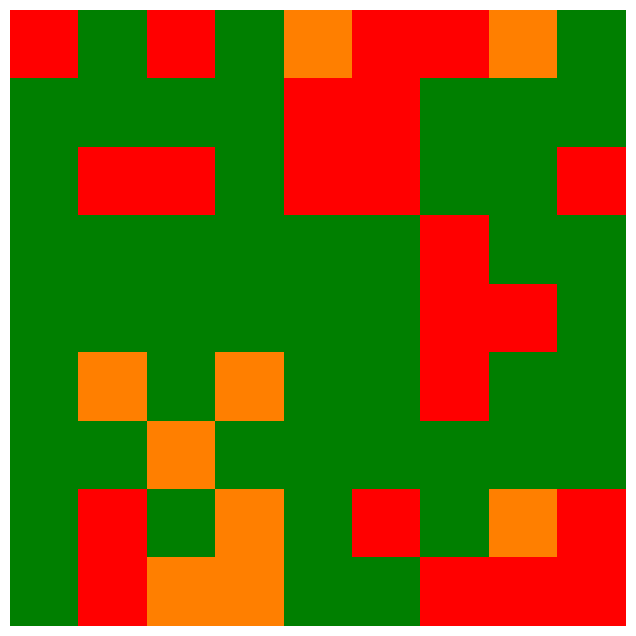

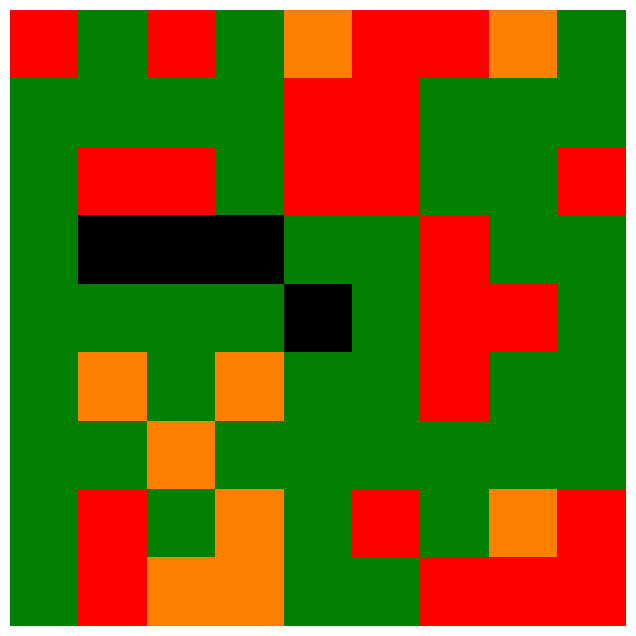

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_land_data(land_data, person_pos=None):
    # Define color mappings
    color_map = {'C': (0, 0.5, 0), 'B': (1, 0, 0), 'F': (1, 0.5, 0)}

    # Create a 9x9 matrix to represent the image
    image = np.zeros((9, 9, 3))

    # Map land_data characters to colors
    for i in range(9):
        for j in range(9):
            if land_data[i][j] in color_map:
                color = color_map[land_data[i][j]]
                image[i, j] = color

    # If person position is specified, color it blue
    if person_pos is not None:
        person_i, person_j = person_pos
        image[person_i, person_j] = (0, 0, 1)

    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def move_person(points, land_data):
    # Create a copy of land_data to track the movements
    land_data_with_person = [list(row) for row in land_data]

    # Move person sequentially through each point
    for i in range(1, len(points)):
        start_i, start_j = points[i - 1]
        end_i, end_j = points[i]

        current_i, current_j = start_i, start_j
        while current_i != end_i or current_j != end_j:
            # Update person's position
            land_data_with_person[current_i][current_j] = 'P'

            # Move person horizontally
            if current_j < end_j:
                current_j += 1
            elif current_j > end_j:
                current_j -= 1

            # Move person vertically
            if current_i < end_i:
                current_i += 1
            elif current_i > end_i:
                current_i -= 1

    # Visualize final state
    visualize_land_data(land_data_with_person)




# Example land data
land_data =['BCBCFBBFC',
           'CCCCBBCCC',
           'CBBCBBCCB',
           'CCCCCCBCC',
           'CCCCCCBBC',
           'CFCFCCBCC',
           'CCFCCCCCC',
           'CBCFCBCFB',
           'CBFFCCBBB']
visualize_land_data(land_data)
# Example: Move person through a list of points
move_person([(4,4),(3,3),(3,2),(3,1),(3,0)], land_data)

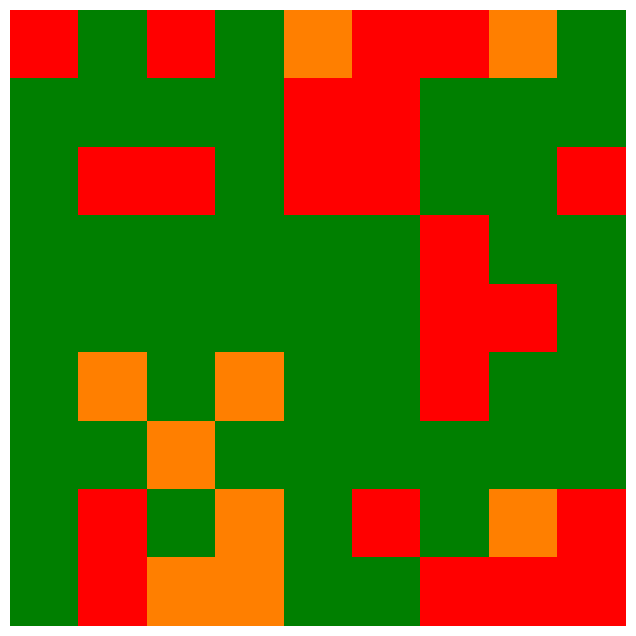

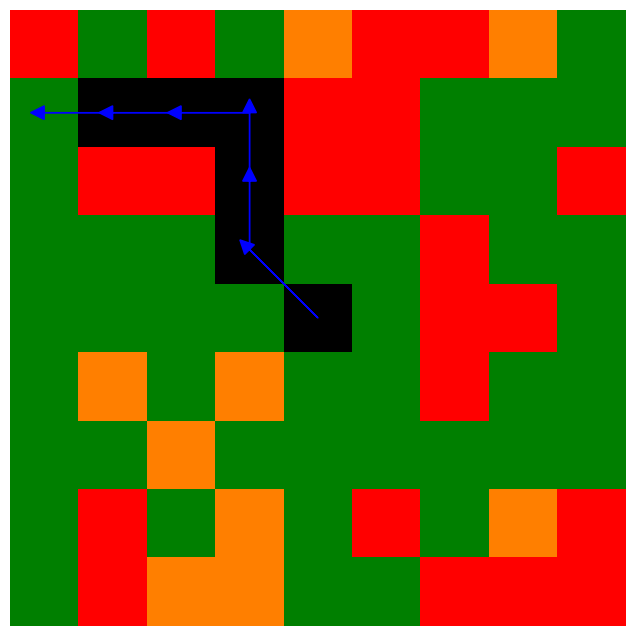

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_land_data_with_arrows(land_data, points):
    # Define color mappings
    color_map = {'C': (0, 0.5, 0), 'B': (1, 0, 0), 'F': (1, 0.5, 0)}

    # Create a 9x9 matrix to represent the image
    image = np.zeros((9, 9, 3))

    # Map land_data characters to colors
    for i in range(9):
        for j in range(9):
            if land_data[i][j] in color_map:
                color = color_map[land_data[i][j]]
                image[i, j] = color

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()
    ax.axis('off')

    # Plot arrows between consecutive points
    for i in range(len(points)-1):
        start = points[i]
        end = points[i + 1]
        dx = end[1] - start[1]
        dy = end[0] - start[0]
        ax.arrow(start[1], start[0], dx, dy, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

    plt.show()

def move_person(points, land_data):
    # Create a copy of land_data to track the movements
    land_data_with_person = [list(row) for row in land_data]

    # Move person sequentially through each point
    for i in range(1, len(points)):
        start_i, start_j = points[i - 1]
        end_i, end_j = points[i]

        current_i, current_j = start_i, start_j
        while current_i != end_i or current_j != end_j:
            # Update person's position
            land_data_with_person[current_i][current_j] = 'P'

            # Move person horizontally
            if current_j < end_j:
                current_j += 1
            elif current_j > end_j:
                current_j -= 1

            # Move person vertically
            if current_i < end_i:
                current_i += 1
            elif current_i > end_i:
                current_i -= 1

    # Visualize final state with arrows
    visualize_land_data_with_arrows(land_data_with_person, points)

# Example land data
land_data =['BCBCFBBFC',
           'CCCCBBCCC',
           'CBBCBBCCB',
           'CCCCCCBCC',
           'CCCCCCBBC',
           'CFCFCCBCC',
           'CCFCCCCCC',
           'CBCFCBCFB',
           'CBFFCCBBB']
visualize_land_data(land_data)
# Example: Move person through a list of points
move_person([(4,4),(3,3),(2,3),(1,3),(1,2),(1,1),(1,0)], land_data)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_land_data_with_legend(land_data, road_color):
    # Define color mappings
    color_map = {'C': (0, 0.5, 0), 'B': (1, 0, 0), 'F': (1, 0.5, 0)}

    # Create a 9x9 matrix to represent the image
    image = np.zeros((9, 9, 3))

    # Map land_data characters to colors
    for i in range(9):
        for j in range(9):
            if land_data[i][j] in color_map:
                color = color_map[land_data[i][j]]
                image[i, j] = color

    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    # Create legend
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color='w', label='Cell with Road', markerfacecolor=road_color, markersize=10),
        plt.Line2D([0], [0], marker='s', color='w', label='Building', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='s', color='w', label='Cell with out Road', markerfacecolor='orange', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.axis('off')
    plt.savefig('land_data_with_legend.png', bbox_inches='tight')  # Save the image with legend
    plt.close()

# Example land data
land_data =['BCBCFBBFC',
           'CCCCBBCCC',
           'CBBCBBCCB',
           'CCCCCCBCC',
           'CCCCCCBBC',
           'CFCFCCBCC',
           'CCFCCCCCC',
           'CBCFCBCFB',
           'CBFFCCBBB']
road_color = 'green'  # Specify the color for the road

# Visualize land data with legend
visualize_land_data_with_legend(land_data, road_color)

